## Installing Necessary Libraries :

In [40]:
!pip install tensorflow
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

## Load the dataset :

In [88]:
file_path = 'data/data 1/monthly_csv.csv'
data = pd.read_csv(file_path)


## Exploratory Data Analysis (EDA) :

In [42]:
# Display the first few rows
data.head(10)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292
5,GISTEMP,2016-10-06,0.8900
6,GCAG,2016-09-06,0.8767
7,GISTEMP,2016-09-06,0.8700
8,GCAG,2016-08-06,0.8998
9,GISTEMP,2016-08-06,0.9800


## Data Preprocessing :

In [85]:
# Check for missing values
data.isnull().sum()

Source    0
Date      0
Mean      0
dtype: int64

## Visualization the data :

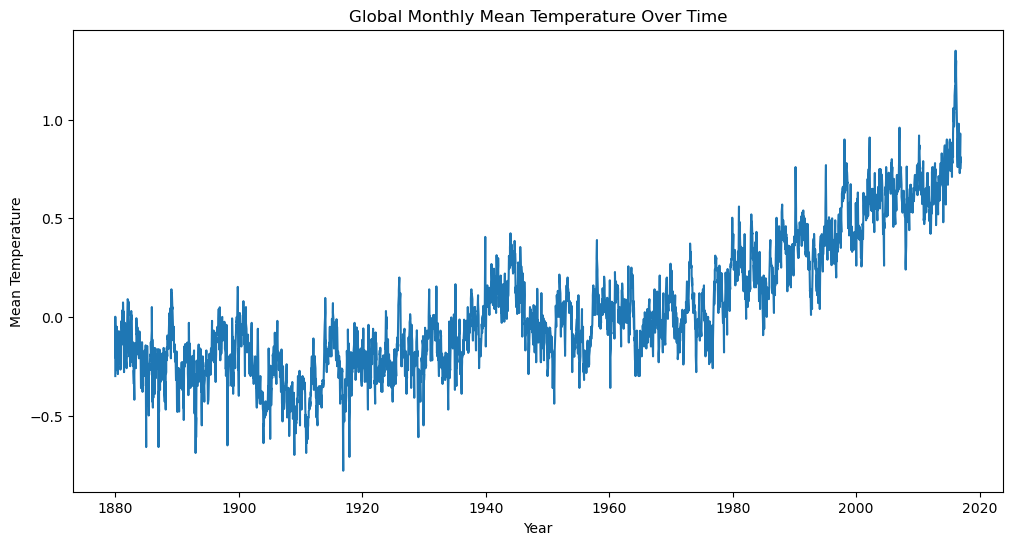

In [86]:
# Plot the Mean Temperature over time
data['Date'] = pd.to_datetime(data['Date'])
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Mean'])
plt.title('Global Monthly Mean Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Temperature')
plt.show()

## Descriptive Statistics of the data :

In [87]:
#Descriptive Statistics of the data
data.describe()

,Mean
count,3288.000000
mean,0.036588
std,0.335255
min,-0.780000
25%,-0.208150
50%,-0.036600
75%,0.240000
max,1.350000


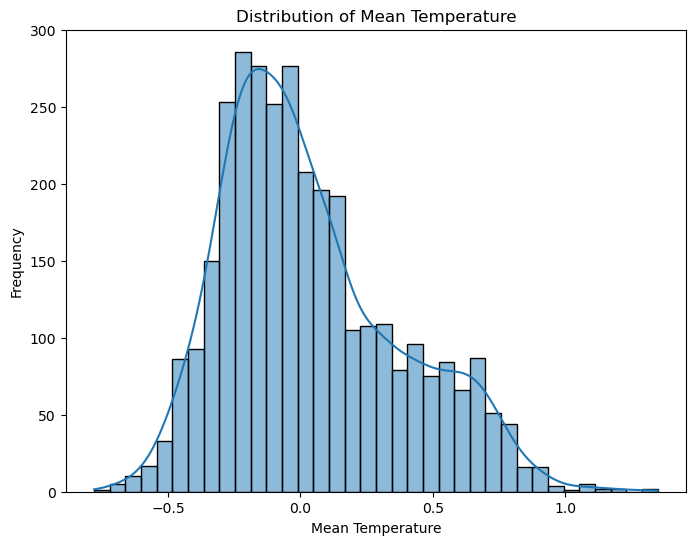

In [46]:
# Distribution of Mean Temperature
plt.figure(figsize=(8,6))
sns.histplot(data['Mean'], kde=True)
plt.title('Distribution of Mean Temperature')
plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.show()

## Data Normalization :

In [ ]:
# Select data from 'GCAG' source and normalize
data_gcag = data[data['Source'] == 'GCAG'].drop('Source', axis=1).set_index('Date')
scaler = MinMaxScaler(feature_range=(0, 1))
data_gcag['Mean'] = scaler.fit_transform(data_gcag['Mean'].values.reshape(-1, 1))

# Define function to create sequences
def create_sequences(dataset, time_step=12):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Create sequences
data_values = data_gcag.values
X, y = create_sequences(data_values)

# Reshape X for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

## Spliting the Data :

In [48]:
# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Defining and Compiling RNN Model :

In [69]:
# Define the RNN model with Dropout for regularization
model = Sequential([
    SimpleRNN(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

## Training the Model :

In [70]:
# Train the model with validation split
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/50
131/131 [==============================] - 3s 9ms/step - loss: 0.1258 - val_loss: 0.0079
Epoch 2/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0252 - val_loss: 0.0036
Epoch 3/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0150 - val_loss: 0.0031
Epoch 4/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0112 - val_loss: 0.0029
Epoch 5/50
131/131 [==============================] - 1s 7ms/step - loss: 0.0100 - val_loss: 0.0028
Epoch 6/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0092 - val_loss: 0.0029
Epoch 7/50
131/131 [==============================] - 1s 7ms/step - loss: 0.0078 - val_loss: 0.0027
Epoch 8/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0068 - val_loss: 0.0029
Epoch 9/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0062 - val_loss: 0.0027
Epoch 10/50
131/131 [==============================] - 1s 6ms/step - loss: 0.0065 - val_loss: 0.0028

In [71]:
model.save('Global Temperature Time Series')

INFO:tensorflow:Assets written to: Global Temperature Time Series\assets


INFO:tensorflow:Assets written to: Global Temperature Time Series\assets


## Evaluating the Model and Ploting Training/Validation Loss :

11/11 [==============================] - 0s 4ms/step - loss: 0.0027
Test Loss: 0.0026714717969298363


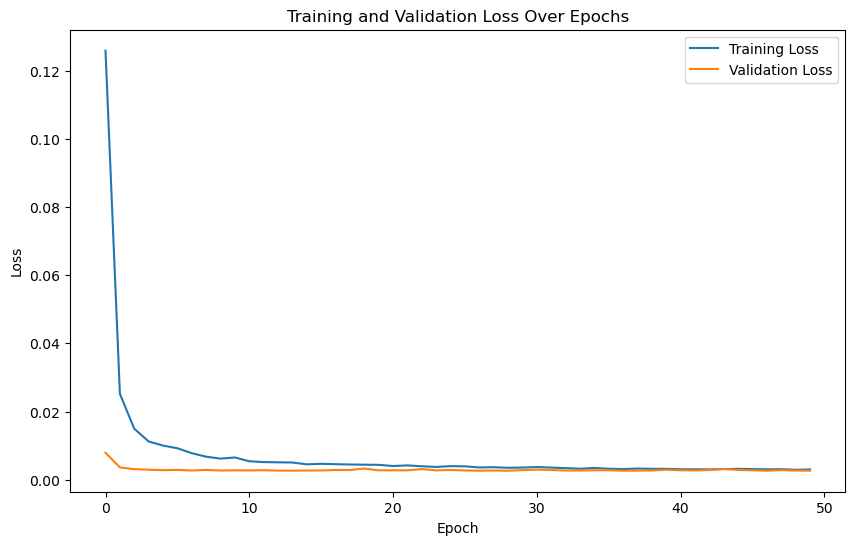

In [72]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [74]:
# Make Predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

11/11 [==============================] - 0s 3ms/step


In [75]:
# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform([y_test])

In [76]:
# Calculating MAE and RMSE
trainScore_MAE = mean_absolute_error(trainY_actual[0], trainPredict[:,0])
trainScore_RMSE = sqrt(mean_squared_error(trainY_actual[0], trainPredict[:,0]))
testScore_MAE = mean_absolute_error(testY_actual[0], testPredict[:,0])
testScore_RMSE = sqrt(mean_squared_error(testY_actual[0], testPredict[:,0]))

In [77]:
# Displaying MAE and RMSE
trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE

(0.07392605272634709,
 0.09634461634106918,
 0.07376795412030653,
 0.09841584648476721)

# Model Improvement :

In [78]:
# Define the RNN model with Dropout for regularization
model1 = Sequential([
    SimpleRNN(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')
# Displaying the Model Summary
model1.summary()
# Training the Model
model1.fit(X_train, y_train, epochs=500, batch_size=30, verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 12, 50)            2600      
                                                                 
 dropout_10 (Dropout)        (None, 12, 50)            0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 50)                5050      
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7701 (30.08 KB)
Trainable params: 7701 (30.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
44/44 - 

Epoch 112/500
44/44 - 0s - loss: 0.0029 - 252ms/epoch - 6ms/step
Epoch 113/500
44/44 - 0s - loss: 0.0029 - 383ms/epoch - 9ms/step
Epoch 114/500
44/44 - 0s - loss: 0.0029 - 292ms/epoch - 7ms/step
Epoch 115/500
44/44 - 0s - loss: 0.0029 - 320ms/epoch - 7ms/step
Epoch 116/500
44/44 - 0s - loss: 0.0029 - 272ms/epoch - 6ms/step
Epoch 117/500
44/44 - 0s - loss: 0.0028 - 297ms/epoch - 7ms/step
Epoch 118/500
44/44 - 0s - loss: 0.0029 - 281ms/epoch - 6ms/step
Epoch 119/500
44/44 - 0s - loss: 0.0029 - 325ms/epoch - 7ms/step
Epoch 120/500
44/44 - 0s - loss: 0.0027 - 287ms/epoch - 7ms/step
Epoch 121/500
44/44 - 0s - loss: 0.0029 - 267ms/epoch - 6ms/step
Epoch 122/500
44/44 - 0s - loss: 0.0028 - 269ms/epoch - 6ms/step
Epoch 123/500
44/44 - 0s - loss: 0.0027 - 282ms/epoch - 6ms/step
Epoch 124/500
44/44 - 0s - loss: 0.0028 - 242ms/epoch - 6ms/step
Epoch 125/500
44/44 - 0s - loss: 0.0028 - 291ms/epoch - 7ms/step
Epoch 126/500
44/44 - 0s - loss: 0.0028 - 253ms/epoch - 6ms/step
Epoch 127/500
44/44 - 0s 

44/44 - 0s - loss: 0.0027 - 250ms/epoch - 6ms/step
Epoch 239/500
44/44 - 0s - loss: 0.0027 - 250ms/epoch - 6ms/step
Epoch 240/500
44/44 - 0s - loss: 0.0028 - 233ms/epoch - 5ms/step
Epoch 241/500
44/44 - 0s - loss: 0.0027 - 235ms/epoch - 5ms/step
Epoch 242/500
44/44 - 0s - loss: 0.0027 - 235ms/epoch - 5ms/step
Epoch 243/500
44/44 - 0s - loss: 0.0027 - 247ms/epoch - 6ms/step
Epoch 244/500
44/44 - 0s - loss: 0.0027 - 235ms/epoch - 5ms/step
Epoch 245/500
44/44 - 0s - loss: 0.0027 - 234ms/epoch - 5ms/step
Epoch 246/500
44/44 - 0s - loss: 0.0027 - 248ms/epoch - 6ms/step
Epoch 247/500
44/44 - 0s - loss: 0.0028 - 232ms/epoch - 5ms/step
Epoch 248/500
44/44 - 0s - loss: 0.0028 - 233ms/epoch - 5ms/step
Epoch 249/500
44/44 - 0s - loss: 0.0026 - 233ms/epoch - 5ms/step
Epoch 250/500
44/44 - 0s - loss: 0.0027 - 249ms/epoch - 6ms/step
Epoch 251/500
44/44 - 0s - loss: 0.0028 - 250ms/epoch - 6ms/step
Epoch 252/500
44/44 - 0s - loss: 0.0028 - 282ms/epoch - 6ms/step
Epoch 253/500
44/44 - 0s - loss: 0.0027

Epoch 365/500
44/44 - 0s - loss: 0.0027 - 317ms/epoch - 7ms/step
Epoch 366/500
44/44 - 0s - loss: 0.0026 - 300ms/epoch - 7ms/step
Epoch 367/500
44/44 - 0s - loss: 0.0027 - 284ms/epoch - 6ms/step
Epoch 368/500
44/44 - 0s - loss: 0.0027 - 269ms/epoch - 6ms/step
Epoch 369/500
44/44 - 0s - loss: 0.0026 - 313ms/epoch - 7ms/step
Epoch 370/500
44/44 - 0s - loss: 0.0028 - 271ms/epoch - 6ms/step
Epoch 371/500
44/44 - 0s - loss: 0.0027 - 272ms/epoch - 6ms/step
Epoch 372/500
44/44 - 0s - loss: 0.0027 - 237ms/epoch - 5ms/step
Epoch 373/500
44/44 - 0s - loss: 0.0027 - 281ms/epoch - 6ms/step
Epoch 374/500
44/44 - 0s - loss: 0.0027 - 290ms/epoch - 7ms/step
Epoch 375/500
44/44 - 0s - loss: 0.0027 - 266ms/epoch - 6ms/step
Epoch 376/500
44/44 - 0s - loss: 0.0027 - 249ms/epoch - 6ms/step
Epoch 377/500
44/44 - 0s - loss: 0.0028 - 272ms/epoch - 6ms/step
Epoch 378/500
44/44 - 0s - loss: 0.0028 - 270ms/epoch - 6ms/step
Epoch 379/500
44/44 - 0s - loss: 0.0028 - 300ms/epoch - 7ms/step
Epoch 380/500
44/44 - 0s 

44/44 - 0s - loss: 0.0027 - 261ms/epoch - 6ms/step
Epoch 492/500
44/44 - 0s - loss: 0.0028 - 386ms/epoch - 9ms/step
Epoch 493/500
44/44 - 0s - loss: 0.0028 - 366ms/epoch - 8ms/step
Epoch 494/500
44/44 - 0s - loss: 0.0028 - 350ms/epoch - 8ms/step
Epoch 495/500
44/44 - 0s - loss: 0.0027 - 258ms/epoch - 6ms/step
Epoch 496/500
44/44 - 0s - loss: 0.0027 - 293ms/epoch - 7ms/step
Epoch 497/500
44/44 - 0s - loss: 0.0027 - 253ms/epoch - 6ms/step
Epoch 498/500
44/44 - 0s - loss: 0.0029 - 250ms/epoch - 6ms/step
Epoch 499/500
44/44 - 0s - loss: 0.0027 - 279ms/epoch - 6ms/step
Epoch 500/500
44/44 - 0s - loss: 0.0028 - 290ms/epoch - 7ms/step


In [79]:
# Make Predictions
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)

11/11 [==============================] - 0s 3ms/step


In [80]:
# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform([y_test])

In [81]:
# Calculating MAE and RMSE
trainScore_MAE = mean_absolute_error(trainY_actual[0], trainPredict[:,0])
trainScore_RMSE = sqrt(mean_squared_error(trainY_actual[0], trainPredict[:,0]))
testScore_MAE = mean_absolute_error(testY_actual[0], testPredict[:,0])
testScore_RMSE = sqrt(mean_squared_error(testY_actual[0], testPredict[:,0]))

In [82]:
# Displaying MAE and RMSE
trainScore_MAE, trainScore_RMSE, testScore_MAE, testScore_RMSE

(0.07539613744721693,
 0.09741848147552216,
 0.07646188836374779,
 0.10014377614579735)